Hints, requirements, and considerations:

* Your bot should scan your account every **five minutes** for mentions.
* Your bot should pull 500 most recent tweets to analyze for each incoming request.
* Your script should prevent abuse by analyzing **only** Twitter accounts that have not previously been analyzed.
* Your plot should include meaningful legend and labels.
* It should also mention the Twitter account name of the requesting user.
* When submitting your assignment, be sure to have at least **three** analyses tweeted out from your account (enlist the help of classmates, friends, or family, if necessary!).
* Notable libraries used to complete this application include: Matplotlib, Pandas, Tweepy, and VADER.
* You may find it helpful to organize your code in function(s), then call them.
* If you're not yet familiar with creating functions in Python, here is a tutorial you may wish to consult: <https://www.tutorialspoint.com/python/python_functions.htm>.

In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import emoji

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter Api Keys
from config import (consumer_key,
                    consumer_secret,
                    access_token,
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
# Define Tweet Analyzer Function Using VADER

def Tweetalyzer(target_user, num_pages):
    '''Takes a target user's twitter handle and the number of pages you want to analyze (there are 20 tweets per page).
    The function uses Vader to run a sentiment analysis on their latest 20*num_pages tweets. 
    It returns a pandas Dataframe containing the compound sentiment analysis of each tweet'''
    
    # Define lists to hold sentiments
    tweet_polarity = []
    tweets_ago = []
    
    # Set tweet number to 0
    tweet_number = 0
    
    for x in range(1, num_pages+1):
        # Get all tweets from home feed
        public_tweets = api.user_timeline(target_user, page=x)
        
        # Loop through all public Tweets
        for tweet in public_tweets:
            
            tweet_text = tweet['text']
            results = analyzer.polarity_scores(tweet_text)
            
            # Append results to list
            tweet_polarity.append(results['compound'])
            tweets_ago.append(tweet_number)
            
            # Move tweet number back in time
            tweet_number -= 1
            
    # Define dictionary of the tweet polarities
    polarity_dict = {'Tweet Polarity':tweet_polarity,
                     'Tweets Ago':tweets_ago}
                
    # Return a pandas dataframe of this dictionary         
    return(pd.DataFrame(polarity_dict))

In [3]:
# Test code on his Tremendousness, King Donald
test_user = '@realdonaldtrump'
test_tweet_polarity = Tweetalyzer(test_user, 3)

# Should be 60 tweets for 3 pages
print(len(test_tweet_polarity))

60


In [4]:
### Dictionary containing the kwargs for the plot
graph_format = {'marker':'o', 
                'grid':True,
                'ylim':(-1.05,1.05), 
                'alpha':0.6,
                'c':'navy',
                'legend':False,
                'figsize':(10,5),
                'marker':'o',
                'markersize':10}

# Assign a variable to the plot image directory
image_path = 'Images/tweet_analysis.png'

# Define a function for plotting the tweet polarity
def PolarityPlotter(polarity_df, user, **graph_kwargs):
    '''This function accepts a dataframe containing a the polarity of user's tweets, the name of the user, and the kwargs for the plot.
    It formats the plot and saves it as tweet_analysis.png'''   
    ax = polarity_df.plot(x="Tweets Ago", y="Tweet Polarity", **graph_kwargs)
    ax.set_ylabel('Tweet Polarity')
    ax.set_xlabel('Tweets Ago')
    ax.set_title(f'Tweet Sentiment Analysis of {user}\nFor their last {len(polarity_df["Tweet Polarity"])} Tweets')
    ax.set_fc("whitesmoke")
    ax.axhline(color='k')
    ax.annotate('Latest Tweet',
                (polarity_df['Tweets Ago'][0]+0.5, polarity_df['Tweet Polarity'][0]+0.05))
    # Smiley face on pos side
    ax.annotate('\U0001F61E',
               (.01,.025), xycoords = 'axes fraction', fontsize=25)
    # Frowny face on neg side
    ax.annotate('\U0001F601',
               (.01,.9), xycoords = 'axes fraction', fontsize=25)
    ax.figure.savefig(image_path)

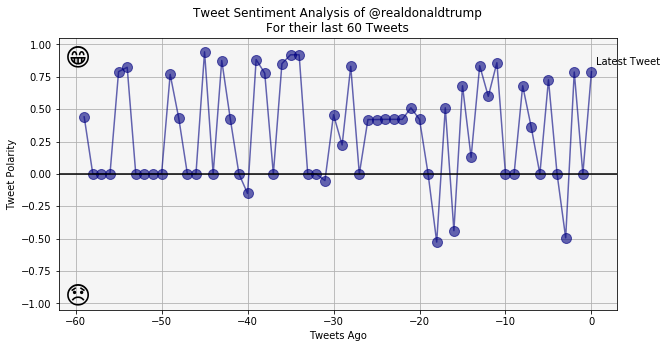

In [5]:
# Make graph for the test user
PolarityPlotter(test_tweet_polarity, test_user, **graph_format)

In [6]:
# Assign variable to my twitter handle
my_handle = '@AlexSta05337262'

# Make empty list to hold the names of accounts we've already checked
analyzed_accts = [] 

# List of Random Compliments
rand_comp = ['You are incredibly handsome and talented.', 'You are your best self.', 
             'You are sagacious and stylish.', "I'm really challenging myself with this one.",
            "I couldn't have chosen better myself."]

# Test if random compliment generator works
i = 0
for i in range(10):
    print({rand_comp[np.random.randint(0,len(rand_comp)-1)]})
    i += 1
    

{'You are sagacious and stylish.'}
{'You are incredibly handsome and talented.'}
{'You are your best self.'}
{'You are sagacious and stylish.'}
{'You are your best self.'}
{'You are sagacious and stylish.'}
{"I'm really challenging myself with this one."}
{'You are incredibly handsome and talented.'}
{'You are sagacious and stylish.'}
{'You are sagacious and stylish.'}


KeyboardInterrupt: 

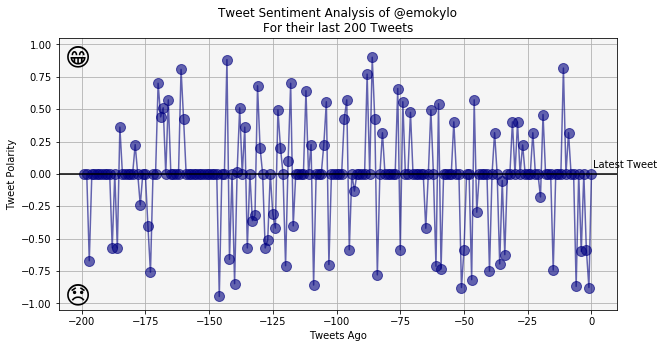

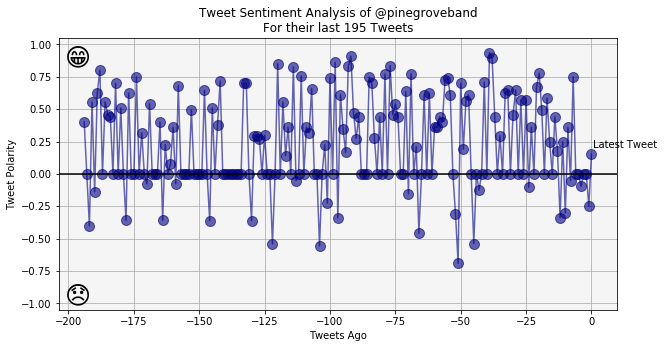

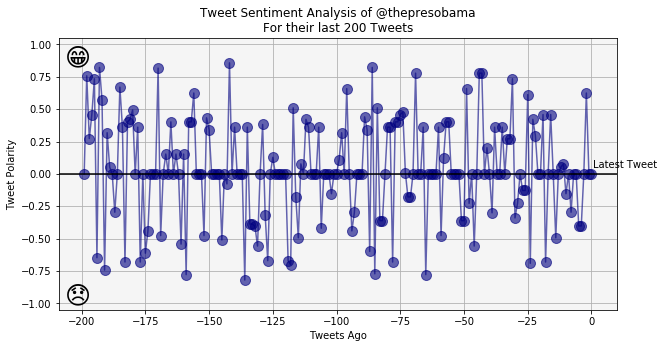

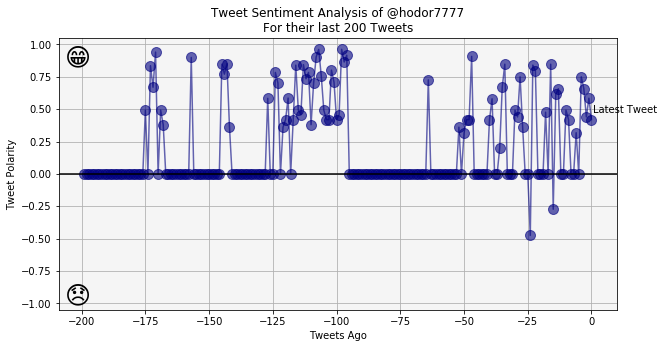

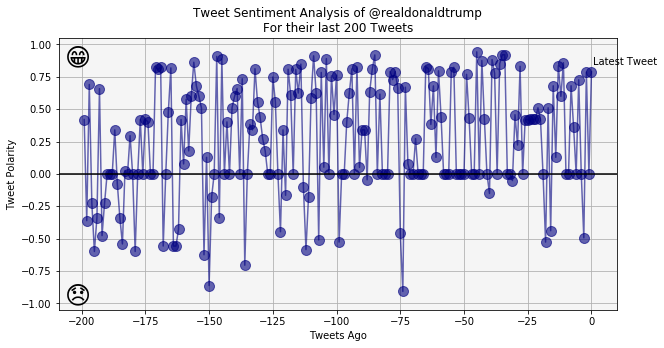

In [7]:
# Infinite Loop, sleep for 5 min between each search. Scour the twitterverse for mentions and analyze when called on.
while(True):
    analysis_reqs = api.search(f'{my_handle} analyze', result_type='recent', count=100)

    for req in analysis_reqs['statuses']:
        '''Remove whitespaces and ':', since people might not be consistent when they ask for analysis. 
        Twitter handles must be alpha numeric, and the search doesn't seem to be case sensitive, 
        so this shouldn't mess up the acquisition'''
        req_text = req['text'].replace(" ", "")
        req_text_clean = req_text.replace(":", "").lower()
        requesting_acct = req['user']['screen_name']
        #print(requesting_acct)
        
        # Acquire analysis target handle, the last element in the list after splitting
        analysis_target = req_text_clean.split('analyze',1)[-1]
        
        # If this is a new target, and if the target isn't empty, perform the analysis
        if analysis_target not in analyzed_accts and analysis_target != '':
            sentiments = Tweetalyzer(analysis_target,10)
            PolarityPlotter(sentiments, analysis_target, **graph_format)
        
            # Append the analysis target into the analyzed_accts list to to make sure they don't get analyzed again
            analyzed_accts.append(analysis_target)
        
            # Post Analysis to Twitter. Make some self-referential humor if I'm the one requesting.
            if requesting_acct == 'AlexSta05337262':
                api.update_with_media(image_path, f"Thanks for the request, @{requesting_acct}! {rand_comp[np.random.randint(0,len(rand_comp)-1)]} Here is the sentiment analysis of {analysis_target}.")

            else:
                api.update_with_media(image_path, f"Thanks for the request, @{requesting_acct}! Here is the sentiment analysis of {analysis_target}.")
    time.sleep(300)
     